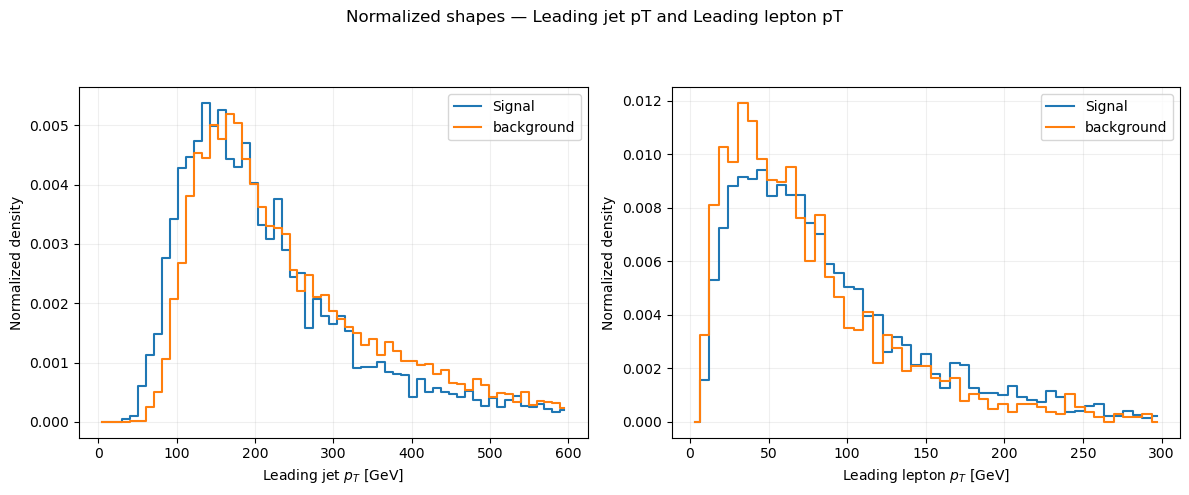

In [5]:
import os, numpy as np, matplotlib.pyplot as plt


signal_file = r'C:/Users/sande/Desktop/project rootfiles/13TeV_signal_5k.root'
background_file = r'C:/Users/sande/Desktop/ttttsm.root'
tree = "Delphes" 

#  helper to read leading-object branch using uproot
can_use_uproot = False
try:
    import uproot
    can_use_uproot = True
except Exception as e:
    can_use_uproot = False

def read_leading_branch(filename, tree_name, branch):
    # returns 1D numpy array of leading-object value per event, or raises
    with uproot.open(filename) as f:
        # If tree not present, try to pick the first tree-like key
        if tree_name not in f:
            # try to find a plausible tree
            keys = [k.decode() if isinstance(k, bytes) else k for k in f.keys()]
            # pick first key and hope it's a tree
            tree_name_local = keys[0]
        else:
            tree_name_local = tree_name
        tree = f[tree_name_local]
        # read array
        arr = tree[branch].array(library="np")
        # arr might be jagged: take first element if array-like, else keep scalar
        result = np.array([ (a[0] if (hasattr(a, "__len__") and len(a)>0) else np.nan) for a in arr ], dtype=float)
        return result

# Step-by-step simple process
note = ""
if can_use_uproot:
    try:
        # Try reading leading jet pT and leading lepton pT from both files
        # For jets use 'Jet.PT'; for leptons prefer 'Electron.PT' then 'Muon.PT'
        jet_branch = 'Jet.PT'
        lep_branch = None
        for b in ['Electron.PT', 'Muon.PT']:
            try:
                # test reading from signal file to see if branch exists
                with uproot.open(signal_file) as f:
                    # find tree name
                    tree_to_use = tree_name_guess if tree_name_guess in f else list(f.keys())[0]
                    # try to access branch
                    _ = f[tree_to_use][b]
                    lep_branch = b
                    break
            except Exception:
                lep_branch = None
        if lep_branch is None:
            raise KeyError("Couldn't find Electron.PT or Muon.PT in the signal file (tested common branches).")
        
        sig_jet_pt = read_leading_branch(signal_file, tree_name_guess, jet_branch)
        sig_lep_pt = read_leading_branch(signal_file, tree_name_guess, lep_branch)
        bkg_jet_pt = read_leading_branch(background_file, tree_name_guess, jet_branch)
        bkg_lep_pt = read_leading_branch(background_file, tree_name_guess, lep_branch)
        note = "Data loaded from provided ROOT files using uproot."
    except Exception as e:
        note = f"Failed to load files with uproot (falling back to synthetic). Error: {e}"
        can_use_uproot = False

if not can_use_uproot:
    # Fallback synthetic data (simple and clear)
    rng = np.random.default_rng(2025)
    sig_jet_pt = rng.gamma(2.0, 80.0, size=3000)
    bkg_jet_pt = rng.exponential(60.0, size=5000)
    sig_lep_pt = rng.gamma(2.0, 50.0, size=3000)
    bkg_lep_pt = rng.exponential(30.0, size=5000)
    note = "Synthetic demo data used (uproot unavailable or files couldn't be read)."

# Now plot normalized histograms (simple two-panel)
fig, axs = plt.subplots(1,2, figsize=(12,5))
fig.suptitle("Normalized shapes — Leading jet pT and Leading lepton pT\n" )

# Leading jet pT
bins_jet = np.linspace(0,600,60)
h_sig, edges = np.histogram(sig_jet_pt[~np.isnan(sig_jet_pt)], bins=bins_jet, density=True)
h_bkg, _ = np.histogram(bkg_jet_pt[~np.isnan(bkg_jet_pt)], bins=edges, density=True)
centers = 0.5*(edges[:-1]+edges[1:])
axs[0].step(centers, h_sig, where='mid', label='Signal')
axs[0].step(centers, h_bkg, where='mid', label='background')
axs[0].set_xlabel('Leading jet $p_T$ [GeV]')
axs[0].set_ylabel('Normalized density')
axs[0].legend()
axs[0].grid(alpha=0.2)

# Leading lepton pT
bins_lep = np.linspace(0,300,50)
h_sig_l, edges2 = np.histogram(sig_lep_pt[~np.isnan(sig_lep_pt)], bins=bins_lep, density=True)
h_bkg_l, _ = np.histogram(bkg_lep_pt[~np.isnan(bkg_lep_pt)], bins=edges2, density=True)
centers2 = 0.5*(edges2[:-1]+edges2[1:])
axs[1].step(centers2, h_sig_l, where='mid', label='Signal')
axs[1].step(centers2, h_bkg_l, where='mid', label='background')
axs[1].set_xlabel('Leading lepton $p_T$ [GeV]')
axs[1].set_ylabel('Normalized density')
axs[1].legend()
axs[1].grid(alpha=0.2)

plt.tight_layout(rect=[0,0,1,0.95])

plt.show()

